In [22]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import roc_auc_score
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score


In [2]:
df = pd.read_csv('../csvs/short_integration_features.csv', index_col=0)
del df['instability_time']
del df['Rel_Eerr_short']
#Nrows = df.shape[0]
#print Nrows, len(np.where(df['Stable']==0)[0])
print df.shape
df.head()

(14999, 116)


,runstring,Stable,Rel_Eerr,t_final_short,avg_a1,std_a1,max_a1,min_a1,norm_std_a1,norm_max_a1,...,avg_iH3,std_iH3,max_iH3,min_iH3,avg_ecross3,std_ecross3,max_ecross3,min_ecross3,norm_a3_slope,Lyapunov_time
0,0000000.bin,0.0,1.099985e-04,10000.0,1.000165,0.000329,1.001248,0.999691,0.000329,0.001083,...,4.706365,0.263380,5.264568,4.410404,0.297364,0.016641,0.339655,0.010871,2.681898e-11,9041.175397
1,0000001.bin,0.0,1.388587e-08,10000.0,0.999952,0.000739,1.002089,0.998309,0.000739,0.002137,...,1.777638,0.610370,2.507803,0.588028,0.115674,0.039718,0.251880,0.137917,-9.314702e-11,2192.382019
2,0000002.bin,0.0,3.048261e-04,10000.0,0.998498,0.001948,1.002043,0.995446,0.001951,0.003550,...,0.982187,0.060058,1.060480,0.875622,0.038930,0.002380,0.026117,0.007227,-4.095504e-11,2191.525922
3,0000003.bin,1.0,6.492574e-10,10000.0,1.000006,0.000026,1.000126,0.999973,0.000026,0.000120,...,9.848375,0.070031,9.914136,9.650551,0.514386,0.003658,0.301072,0.279903,-7.257099e-12,58599.215966
4,0000004.bin,0.0,9.336734e-07,10000.0,1.067267,0.030186,1.121364,1.000000,0.028284,0.063028,...,1.453843,0.726529,2.660701,0.154157,0.496372,0.248052,1.358604,0.261358,-2.610208e-08,43524.152375


In [3]:
#"['daOverRH1' 'daOverRH2' 'mindaOverRH' 'maxdaOverRH' 'norm_LyapunovTime']"
features = []
features += ['avg_iH1', 'avg_iH2']
features += ['norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1']
features += ['norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2']
features += ['norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3']
features += ['avg_ecross1', 'std_ecross1', 'max_ecross1', 'min_ecross1']
features += ['avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2']
features += ['avg_ecross3', 'std_ecross3', 'max_ecross3', 'min_ecross3']
features += ['norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope']
features += ['Lyapunov_time']

y = df['Stable']
X = df[features]
X.head()

,avg_iH1,avg_iH2,norm_std_a1,norm_max_a1,norm_std_window10_a1,norm_max_window10_a1,norm_std_a2,norm_max_a2,norm_std_window10_a2,norm_max_window10_a2,...,max_ecross2,min_ecross2,avg_ecross3,std_ecross3,max_ecross3,min_ecross3,norm_a1_slope,norm_a2_slope,norm_a3_slope,Lyapunov_time
0,0.396282,0.481704,0.000329,0.001083,0.000214,0.000456,0.000701,0.001978,0.000446,0.000964,...,0.333921,0.077775,0.297364,0.016641,0.339655,0.010871,-9.963524e-11,2.144832e-10,2.681898e-11,9041.175397
1,1.034575,0.823935,0.000739,0.002137,0.000202,0.000463,0.000200,0.000350,0.000226,0.000377,...,0.307149,0.075092,0.115674,0.039718,0.251880,0.137917,-4.938423e-11,3.559377e-11,-9.314702e-11,2192.382019
2,0.440470,0.491261,0.001951,0.003550,0.001735,0.002860,0.002303,0.004034,0.002080,0.003409,...,0.583040,0.328325,0.038930,0.002380,0.026117,0.007227,6.451005e-11,-3.330088e-11,-4.095504e-11,2191.525922
3,0.432098,0.550624,0.000026,0.000120,0.000005,0.000009,0.000019,0.000050,0.000016,0.000041,...,0.048402,0.000124,0.514386,0.003658,0.301072,0.279903,8.676076e-12,7.816527e-13,-7.257099e-12,58599.215966
4,5.722053,17.442426,0.028284,0.063028,0.004313,0.010716,0.038832,0.160685,0.090892,0.112168,...,9.321252,0.823132,0.496372,0.248052,1.358604,0.261358,6.816926e-08,3.913858e-08,-2.610208e-08,43524.152375


In [4]:
Nrows = int(X.shape[0] * 0.4)
trainX = X.iloc[:Nrows,:]
trainY = y.iloc[:Nrows]
testX = X.iloc[Nrows:, :]
testY = y.iloc[Nrows:]

Don't worry about number of estimators, learning rate, or colsample_by_tree for now, come back to it afterwards

In [33]:
space ={
        'max_depth': hp.randint('x_max_depth',  10),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1)
}

In [34]:
def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'],
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'])

    eval_set  = [( testX, testY)]

    clf.fit(trainX, trainY,
            eval_set=eval_set, eval_metric="auc", 
            early_stopping_rounds=10)

    pred = clf.predict_proba(testX)[:,1]
    auc = roc_auc_score(testY, pred)
    print "SCORE:", auc

    return{'loss':1-auc, 'status': STATUS_OK }

In [35]:
trials = Trials()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 10, trials = trials)

[0]	validation_0-auc:0.951785
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.957419
[2]	validation_0-auc:0.963815
[3]	validation_0-auc:0.965524
[4]	validation_0-auc:0.966899
[5]	validation_0-auc:0.967631
[6]	validation_0-auc:0.968524
[7]	validation_0-auc:0.96913
[8]	validation_0-auc:0.969823
[9]	validation_0-auc:0.970551
[10]	validation_0-auc:0.971245
[11]	validation_0-auc:0.971794
[12]	validation_0-auc:0.972109
[13]	validation_0-auc:0.972355
[14]	validation_0-auc:0.972381
[15]	validation_0-auc:0.972674
[16]	validation_0-auc:0.973038
[17]	validation_0-auc:0.973067
[18]	validation_0-auc:0.973223
[19]	validation_0-auc:0.973205
[20]	validation_0-auc:0.973451
[21]	validation_0-auc:0.973686
[22]	validation_0-auc:0.973759
[23]	validation_0-auc:0.973898
[24]	validation_0-auc:0.974018
[25]	validation_0-auc:0.974004
[26]	validation_0-auc:0.974179
[27]	validation_0-auc:0.974405
[28]	validation_0-auc:0.974505
[29]	validation_0-auc:0.974695
[30]	validation_0

[29]	validation_0-auc:0.974673
[30]	validation_0-auc:0.974753
[31]	validation_0-auc:0.974842
[32]	validation_0-auc:0.974981
[33]	validation_0-auc:0.975008
[34]	validation_0-auc:0.975016
[35]	validation_0-auc:0.97503
[36]	validation_0-auc:0.975104
[37]	validation_0-auc:0.975171
[38]	validation_0-auc:0.975242
[39]	validation_0-auc:0.975261
[40]	validation_0-auc:0.975355
[41]	validation_0-auc:0.975415
[42]	validation_0-auc:0.975472
[43]	validation_0-auc:0.975518
[44]	validation_0-auc:0.975547
[45]	validation_0-auc:0.975546
[46]	validation_0-auc:0.975547
[47]	validation_0-auc:0.975556
[48]	validation_0-auc:0.975554
[49]	validation_0-auc:0.975576
[50]	validation_0-auc:0.975596
[51]	validation_0-auc:0.975651
[52]	validation_0-auc:0.975654
[53]	validation_0-auc:0.975677
[54]	validation_0-auc:0.975746
[55]	validation_0-auc:0.975715
[56]	validation_0-auc:0.97577
[57]	validation_0-auc:0.975835
[58]	validation_0-auc:0.975897
[59]	validation_0-auc:0.975935
[60]	validation_0-auc:0.97597
[61]	valida

[47]	validation_0-auc:0.975247
[48]	validation_0-auc:0.975343
[49]	validation_0-auc:0.975369
[50]	validation_0-auc:0.975367
[51]	validation_0-auc:0.975401
[52]	validation_0-auc:0.975465
[53]	validation_0-auc:0.97556
[54]	validation_0-auc:0.975676
[55]	validation_0-auc:0.9757
[56]	validation_0-auc:0.975712
[57]	validation_0-auc:0.975768
[58]	validation_0-auc:0.975836
[59]	validation_0-auc:0.975862
[60]	validation_0-auc:0.975966
[61]	validation_0-auc:0.975976
[62]	validation_0-auc:0.975962
[63]	validation_0-auc:0.975975
[64]	validation_0-auc:0.976024
[65]	validation_0-auc:0.976081
[66]	validation_0-auc:0.976143
[67]	validation_0-auc:0.976161
[68]	validation_0-auc:0.976174
[69]	validation_0-auc:0.976181
[70]	validation_0-auc:0.976169
[71]	validation_0-auc:0.976198
[72]	validation_0-auc:0.976244
[73]	validation_0-auc:0.976296
[74]	validation_0-auc:0.976342
[75]	validation_0-auc:0.976371
[76]	validation_0-auc:0.97634
[77]	validation_0-auc:0.97637
[78]	validation_0-auc:0.976397
[79]	validati

[6]	validation_0-auc:0.5
[7]	validation_0-auc:0.5
[8]	validation_0-auc:0.5
[9]	validation_0-auc:0.5
[10]	validation_0-auc:0.5
Stopping. Best iteration:
[0]	validation_0-auc:0.5

SCORE: 0.5


In [36]:
print best.values
print best

<built-in method values of dict object at 0x7fde9bee3168>
{'x_min_child': 3.0, 'x_max_depth': 4, 'x_subsample': 0.8208114778249397}


In [45]:
space2 ={
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
        'learning_rate': hp.uniform ('x_learning_rate', 0.001, 0.1),
         #'subsample': hp.uniform ('x_subsample', 0.8, 1)

}

In [87]:
def objective2(space2):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = 4, min_child_weight = 3,
                            colsample_bytree =space2['colsample_bytree'],
                            learning_rate = space2['learning_rate'],
                            subsample = .83)

    eval_set  = [( testX, testY)]

    clf.fit(trainX, trainY,
            eval_set=eval_set, eval_metric="auc", 
            early_stopping_rounds=10)

    pred = clf.predict_proba(testX)[:,1]
    auc = roc_auc_score(testY, pred)
    print "SCORE:", auc

    return{'loss':1-auc, 'status': STATUS_OK , 'score':auc}

In [88]:
trials = Trials()
best2 = fmin(fn=objective2, space = space2, algo = tpe.suggest, max_evals = 10, trials = trials)

[0]	validation_0-auc:0.941312
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.9563
[2]	validation_0-auc:0.959931
[3]	validation_0-auc:0.962481
[4]	validation_0-auc:0.963278
[5]	validation_0-auc:0.964299
[6]	validation_0-auc:0.96558
[7]	validation_0-auc:0.96578
[8]	validation_0-auc:0.967218
[9]	validation_0-auc:0.967528
[10]	validation_0-auc:0.967742
[11]	validation_0-auc:0.968639
[12]	validation_0-auc:0.969124
[13]	validation_0-auc:0.96907
[14]	validation_0-auc:0.969617
[15]	validation_0-auc:0.96987
[16]	validation_0-auc:0.97049
[17]	validation_0-auc:0.970942
[18]	validation_0-auc:0.971386
[19]	validation_0-auc:0.971756
[20]	validation_0-auc:0.972014
[21]	validation_0-auc:0.972241
[22]	validation_0-auc:0.972503
[23]	validation_0-auc:0.972695
[24]	validation_0-auc:0.972852
[25]	validation_0-auc:0.972899
[26]	validation_0-auc:0.973079
[27]	validation_0-auc:0.973254
[28]	validation_0-auc:0.973454
[29]	validation_0-auc:0.973385
[30]	validation_0-auc:0

[60]	validation_0-auc:0.975973
[61]	validation_0-auc:0.97605
[62]	validation_0-auc:0.976102
[63]	validation_0-auc:0.976143
[64]	validation_0-auc:0.97622
[65]	validation_0-auc:0.976249
[66]	validation_0-auc:0.976248
[67]	validation_0-auc:0.976281
[68]	validation_0-auc:0.976284
[69]	validation_0-auc:0.976304
[70]	validation_0-auc:0.976259
[71]	validation_0-auc:0.976271
[72]	validation_0-auc:0.976304
[73]	validation_0-auc:0.976299
[74]	validation_0-auc:0.976364
[75]	validation_0-auc:0.976402
[76]	validation_0-auc:0.97642
[77]	validation_0-auc:0.976439
[78]	validation_0-auc:0.976465
[79]	validation_0-auc:0.976475
[80]	validation_0-auc:0.976515
[81]	validation_0-auc:0.976523
[82]	validation_0-auc:0.976518
[83]	validation_0-auc:0.97653
[84]	validation_0-auc:0.976556
[85]	validation_0-auc:0.976583
[86]	validation_0-auc:0.976625
[87]	validation_0-auc:0.976654
[88]	validation_0-auc:0.976677
[89]	validation_0-auc:0.976668
[90]	validation_0-auc:0.976681
[91]	validation_0-auc:0.976686
[92]	validat

[18]	validation_0-auc:0.969641
[19]	validation_0-auc:0.970035
[20]	validation_0-auc:0.97045
[21]	validation_0-auc:0.970527
[22]	validation_0-auc:0.970716
[23]	validation_0-auc:0.971074
[24]	validation_0-auc:0.971342
[25]	validation_0-auc:0.971548
[26]	validation_0-auc:0.97176
[27]	validation_0-auc:0.971933
[28]	validation_0-auc:0.972082
[29]	validation_0-auc:0.972086
[30]	validation_0-auc:0.972318
[31]	validation_0-auc:0.97227
[32]	validation_0-auc:0.972322
[33]	validation_0-auc:0.972511
[34]	validation_0-auc:0.972601
[35]	validation_0-auc:0.97278
[36]	validation_0-auc:0.972925
[37]	validation_0-auc:0.973086
[38]	validation_0-auc:0.973269
[39]	validation_0-auc:0.973412
[40]	validation_0-auc:0.973535
[41]	validation_0-auc:0.973666
[42]	validation_0-auc:0.973857
[43]	validation_0-auc:0.973973
[44]	validation_0-auc:0.974054
[45]	validation_0-auc:0.97417
[46]	validation_0-auc:0.974204
[47]	validation_0-auc:0.974265
[48]	validation_0-auc:0.974292
[49]	validation_0-auc:0.974374
[50]	validati

[78]	validation_0-auc:0.976165
[79]	validation_0-auc:0.976227
[80]	validation_0-auc:0.976262
[81]	validation_0-auc:0.976299
[82]	validation_0-auc:0.976309
[83]	validation_0-auc:0.976334
[84]	validation_0-auc:0.97638
[85]	validation_0-auc:0.976379
[86]	validation_0-auc:0.976384
[87]	validation_0-auc:0.976412
[88]	validation_0-auc:0.976487
[89]	validation_0-auc:0.976498
[90]	validation_0-auc:0.976533
[91]	validation_0-auc:0.97654
[92]	validation_0-auc:0.976558
[93]	validation_0-auc:0.976597
[94]	validation_0-auc:0.976631
[95]	validation_0-auc:0.976629
[96]	validation_0-auc:0.976669
[97]	validation_0-auc:0.976709
[98]	validation_0-auc:0.97673
[99]	validation_0-auc:0.976759
SCORE: 0.976759355103
[0]	validation_0-auc:0.936069
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.954861
[2]	validation_0-auc:0.955867
[3]	validation_0-auc:0.957866
[4]	validation_0-auc:0.961753
[5]	validation_0-auc:0.961325
[6]	validation_0-auc:0.962973
[7]	validation_0-auc:0.96

In [89]:
print best
print best2
#print trials.results

{'x_min_child': 3.0, 'x_max_depth': 4, 'x_subsample': 0.8208114778249397}
{'x_tree_colsample': 0.5211119911549739, 'x_learning_rate': 0.0747755799820947}


In [91]:
#combine the two spaces
best_model = XGBClassifier(seed = 0, learning_rate=0.0797, min_child_weight=3, \
                            max_depth= 4, subsample = 0.82, colsample_bytree = 0.996)

best_model.fit(trainX, trainY)
pred = best_model.predict_proba(testX)[:,1]
score = roc_auc_score(testY, pred)
print score

0.976856915881


In [92]:
#Check cross val score, ensure that its not overfitting
score = cross_val_score(best_model, X, y, cv = 5, scoring = 'average_precision')
print np.mean(score), np.std(score)

0.965755289395 0.00105270136101


Does surprizingly well despite the rediculous amount of features in the dataset(116). We could definetly remove some, and could probably spped this up even faster, and possible get a better score by removing not very useful features

In [93]:
best_model.feature_importances_

array([ 0.01445348,  0.01987353,  0.01716351,  0.02710027,  0.01445348,
        0.01626016,  0.05239386,  0.06323396,  0.01264679,  0.02077688,
        0.02168022,  0.01716351,  0.01445348,  0.00722674,  0.04245709,
        0.02168022,  0.06775068,  0.0298103 ,  0.04968383,  0.04516712,
        0.1065944 ,  0.02529359,  0.04516712,  0.02800361,  0.06142728,
        0.01264679,  0.02168022,  0.03342367,  0.03252032,  0.05781391], dtype=float32)

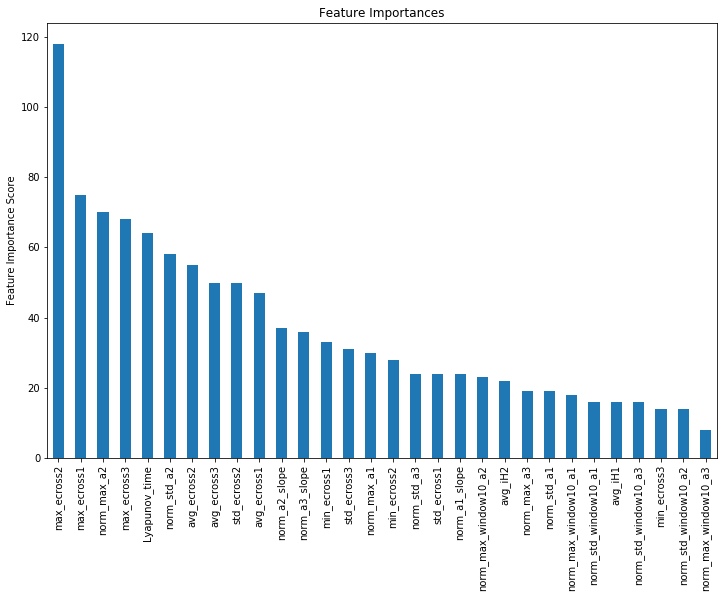

In [60]:
# feature importances
feat_imp = pd.Series(best_model.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()


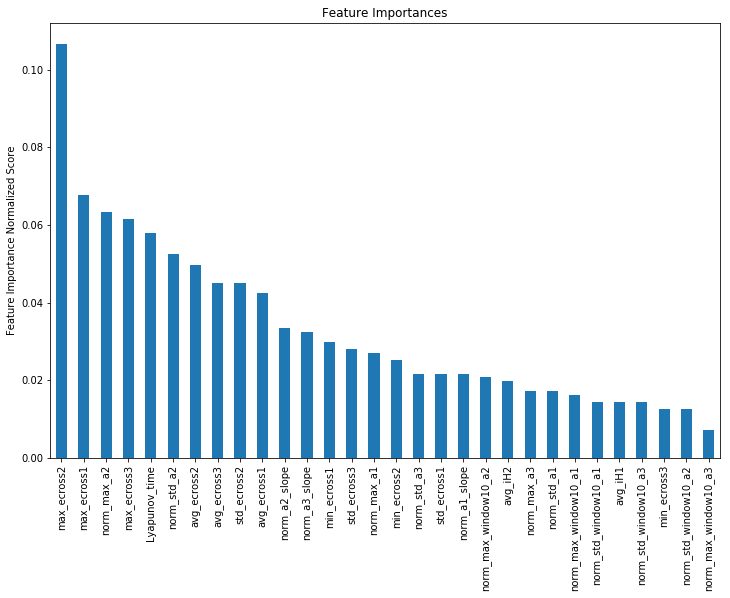

In [64]:
#try drawing a normalized version of the plot
feat_imp_norm = pd.Series(best_model.booster().get_fscore()).sort_values(ascending=False)
feat_imp_norm = feat_imp_norm/np.sum(feat_imp_norm)
#print feat_imp_norm
feat_imp_norm.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Normalized Score')
plt.show()

In [130]:
total_scores = [val['result']['score'] for val in trials]

In [131]:
print np.mean(total_scores), np.std(total_scores)

0.975328414489 0.00311081310424


Try running the parameters together, and see if they change due to partial dependencies between any of them. Also increase number of iterations to ensure it has reached the optimal parameter space

In [5]:
space3 ={
        'max_depth': hp.quniform('x_max_depth', 1, 10,1),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
        'learning_rate': hp.uniform ('x_learning_rate', 0.001, 0.1)
}

In [6]:
def objective3(space3):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space3['max_depth'], 
                            min_child_weight =space3['min_child_weight'],
                            subsample = space3['subsample'],
                            colsample_bytree =space3['colsample_bytree'],
                            learning_rate = space3['learning_rate'])

    eval_set  = [( testX, testY)]

    clf.fit(trainX, trainY,
            eval_set=eval_set, eval_metric="auc", 
            early_stopping_rounds=20)

    pred = clf.predict_proba(testX)[:,1]
    auc = roc_auc_score(testY, pred)
    print "SCORE:", auc

    return{'loss':1-auc, 'status': STATUS_OK , 'score':auc}

In [7]:
trials3 = Trials()
import time
start = time.time()
best3 = fmin(fn=objective3, space = space3, algo = tpe.suggest, max_evals = 10, trials = trials3)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

[0]	validation_0-auc:0.950999
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.958896
[2]	validation_0-auc:0.964985
[3]	validation_0-auc:0.965588
[4]	validation_0-auc:0.968049
[5]	validation_0-auc:0.968918
[6]	validation_0-auc:0.969385
[7]	validation_0-auc:0.970561
[8]	validation_0-auc:0.97149
[9]	validation_0-auc:0.971355
[10]	validation_0-auc:0.971803
[11]	validation_0-auc:0.972411
[12]	validation_0-auc:0.972753
[13]	validation_0-auc:0.972859
[14]	validation_0-auc:0.973266
[15]	validation_0-auc:0.97334
[16]	validation_0-auc:0.973596
[17]	validation_0-auc:0.973784
[18]	validation_0-auc:0.974114
[19]	validation_0-auc:0.974258
[20]	validation_0-auc:0.974386
[21]	validation_0-auc:0.974609
[22]	validation_0-auc:0.974874
[23]	validation_0-auc:0.974935
[24]	validation_0-auc:0.975081
[25]	validation_0-auc:0.975043
[26]	validation_0-auc:0.97515
[27]	validation_0-auc:0.975287
[28]	validation_0-auc:0.975401
[29]	validation_0-auc:0.975547
[30]	validation_0-a

[78]	validation_0-auc:0.974867
[79]	validation_0-auc:0.9749
[80]	validation_0-auc:0.974975
[81]	validation_0-auc:0.975018
[82]	validation_0-auc:0.975045
[83]	validation_0-auc:0.97509
[84]	validation_0-auc:0.975145
[85]	validation_0-auc:0.975187
[86]	validation_0-auc:0.975212
[87]	validation_0-auc:0.975217
[88]	validation_0-auc:0.975256
[89]	validation_0-auc:0.9753
[90]	validation_0-auc:0.975359
[91]	validation_0-auc:0.97542
[92]	validation_0-auc:0.975455
[93]	validation_0-auc:0.975507
[94]	validation_0-auc:0.975562
[95]	validation_0-auc:0.975608
[96]	validation_0-auc:0.975625
[97]	validation_0-auc:0.975659
[98]	validation_0-auc:0.975669
[99]	validation_0-auc:0.975689
SCORE: 0.975689112326
[0]	validation_0-auc:0.952851
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.962304
[2]	validation_0-auc:0.965064
[3]	validation_0-auc:0.965948
[4]	validation_0-auc:0.967202
[5]	validation_0-auc:0.967671
[6]	validation_0-auc:0.969199
[7]	validation_0-auc:0.96970

[37]	validation_0-auc:0.973488
[38]	validation_0-auc:0.973533
[39]	validation_0-auc:0.973636
[40]	validation_0-auc:0.973656
[41]	validation_0-auc:0.973711
[42]	validation_0-auc:0.973806
[43]	validation_0-auc:0.973772
[44]	validation_0-auc:0.973846
[45]	validation_0-auc:0.973888
[46]	validation_0-auc:0.973953
[47]	validation_0-auc:0.973997
[48]	validation_0-auc:0.974054
[49]	validation_0-auc:0.974118
[50]	validation_0-auc:0.974162
[51]	validation_0-auc:0.974196
[52]	validation_0-auc:0.974297
[53]	validation_0-auc:0.974314
[54]	validation_0-auc:0.974374
[55]	validation_0-auc:0.97439
[56]	validation_0-auc:0.974418
[57]	validation_0-auc:0.974451
[58]	validation_0-auc:0.974509
[59]	validation_0-auc:0.974612
[60]	validation_0-auc:0.974649
[61]	validation_0-auc:0.974671
[62]	validation_0-auc:0.974718
[63]	validation_0-auc:0.974733
[64]	validation_0-auc:0.974766
[65]	validation_0-auc:0.974817
[66]	validation_0-auc:0.974886
[67]	validation_0-auc:0.974911
[68]	validation_0-auc:0.97496
[69]	valid

[98]	validation_0-auc:0.968244
[99]	validation_0-auc:0.968335
SCORE: 0.968334821342
[0]	validation_0-auc:0.931672
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.935714
[2]	validation_0-auc:0.942346
[3]	validation_0-auc:0.949571
[4]	validation_0-auc:0.954704
[5]	validation_0-auc:0.955575
[6]	validation_0-auc:0.95675
[7]	validation_0-auc:0.958696
[8]	validation_0-auc:0.960949
[9]	validation_0-auc:0.961022
[10]	validation_0-auc:0.961985
[11]	validation_0-auc:0.962718
[12]	validation_0-auc:0.963249
[13]	validation_0-auc:0.963434
[14]	validation_0-auc:0.964093
[15]	validation_0-auc:0.964898
[16]	validation_0-auc:0.965073
[17]	validation_0-auc:0.965502
[18]	validation_0-auc:0.966154
[19]	validation_0-auc:0.966681
[20]	validation_0-auc:0.967045
[21]	validation_0-auc:0.96759
[22]	validation_0-auc:0.968049
[23]	validation_0-auc:0.968394
[24]	validation_0-auc:0.96864
[25]	validation_0-auc:0.968916
[26]	validation_0-auc:0.969295
[27]	validation_0-auc:0.9694

In [8]:
scores = [val["result"]['score'] for val in trials3]
losses = [val["result"]['loss'] for val in trials3]

In [9]:
print np.mean(scores), np.std(scores)

0.975134235398 0.00253902763879


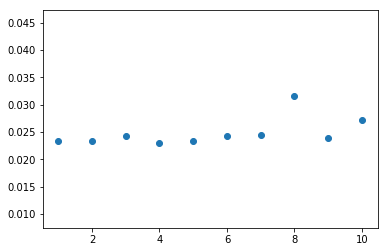

In [12]:
plt.scatter(np.linspace(1,10,10),losses)
plt.show()

In [16]:
print best3["x_learning_rate"]
print best3

0.0517038760567
{'x_min_child': 7.0, 'x_tree_colsample': 0.5994413933708563, 'x_max_depth': 10.0, 'x_subsample': 0.836607086657213, 'x_learning_rate': 0.05170387605667589}


In [20]:
#combine the two spaces
best_model2 = XGBClassifier(seed = 0, learning_rate=best3["x_learning_rate"],
                            min_child_weight=best3["x_min_child"],
                            max_depth= int(best3["x_max_depth"]), 
                            subsample = best3["x_subsample"],
                            colsample_bytree = best3["x_tree_colsample"])

best_model2.fit(trainX, trainY)
pred = best_model2.predict_proba(testX)[:,1]
score = roc_auc_score(testY, pred)
print score

0.976951136601


In [159]:
import hyperopt
hyperopt.__file__

'/mnt/raid-cita/nhussain/venv-2.7.13/lib/python2.7/site-packages/hyperopt/__init__.pyc'

In [23]:
#Check cross validated grid scores
score = cross_val_score(best_model2, X, y, cv = 5, scoring = 'average_precision')
print np.mean(score), np.std(score)

0.966752337507 0.000872924370947


The result is still very good, so then these parameters generate a model that generalizes fairly well

In [24]:
#Try again with 100 trials
trials3_more = Trials()
best3_more = fmin(fn=objective3, space = space3, algo = tpe.suggest, max_evals = 100, trials = trials3_more)

[0]	validation_0-auc:0.9479
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.955313
[2]	validation_0-auc:0.958729
[3]	validation_0-auc:0.960328
[4]	validation_0-auc:0.963452
[5]	validation_0-auc:0.964612
[6]	validation_0-auc:0.965734
[7]	validation_0-auc:0.967504
[8]	validation_0-auc:0.968985
[9]	validation_0-auc:0.969496
[10]	validation_0-auc:0.969902
[11]	validation_0-auc:0.969962
[12]	validation_0-auc:0.970595
[13]	validation_0-auc:0.970942
[14]	validation_0-auc:0.971337
[15]	validation_0-auc:0.971822
[16]	validation_0-auc:0.972102
[17]	validation_0-auc:0.97253
[18]	validation_0-auc:0.972705
[19]	validation_0-auc:0.97293
[20]	validation_0-auc:0.973307
[21]	validation_0-auc:0.973543
[22]	validation_0-auc:0.973755
[23]	validation_0-auc:0.97393
[24]	validation_0-auc:0.974057
[25]	validation_0-auc:0.974087
[26]	validation_0-auc:0.974201
[27]	validation_0-auc:0.974257
[28]	validation_0-auc:0.974336
[29]	validation_0-auc:0.974408
[30]	validation_0-auc

[60]	validation_0-auc:0.970646
[61]	validation_0-auc:0.970752
[62]	validation_0-auc:0.970876
[63]	validation_0-auc:0.97104
[64]	validation_0-auc:0.971089
[65]	validation_0-auc:0.97131
[66]	validation_0-auc:0.971464
[67]	validation_0-auc:0.971589
[68]	validation_0-auc:0.97166
[69]	validation_0-auc:0.971811
[70]	validation_0-auc:0.971962
[71]	validation_0-auc:0.972118
[72]	validation_0-auc:0.97228
[73]	validation_0-auc:0.972374
[74]	validation_0-auc:0.972561
[75]	validation_0-auc:0.972602
[76]	validation_0-auc:0.972718
[77]	validation_0-auc:0.972786
[78]	validation_0-auc:0.972894
[79]	validation_0-auc:0.97307
[80]	validation_0-auc:0.973084
[81]	validation_0-auc:0.973191
[82]	validation_0-auc:0.9732
[83]	validation_0-auc:0.973315
[84]	validation_0-auc:0.97334
[85]	validation_0-auc:0.973467
[86]	validation_0-auc:0.973559
[87]	validation_0-auc:0.973587
[88]	validation_0-auc:0.973653
[89]	validation_0-auc:0.973704
[90]	validation_0-auc:0.973811
[91]	validation_0-auc:0.973798
[92]	validation_

[18]	validation_0-auc:0.957657
[19]	validation_0-auc:0.958166
[20]	validation_0-auc:0.958312
[21]	validation_0-auc:0.958488
[22]	validation_0-auc:0.959507
[23]	validation_0-auc:0.959941
[24]	validation_0-auc:0.961014
[25]	validation_0-auc:0.961403
[26]	validation_0-auc:0.962069
[27]	validation_0-auc:0.962799
[28]	validation_0-auc:0.963542
[29]	validation_0-auc:0.963634
[30]	validation_0-auc:0.964138
[31]	validation_0-auc:0.964498
[32]	validation_0-auc:0.965123
[33]	validation_0-auc:0.965613
[34]	validation_0-auc:0.966002
[35]	validation_0-auc:0.966459
[36]	validation_0-auc:0.966761
[37]	validation_0-auc:0.967178
[38]	validation_0-auc:0.967401
[39]	validation_0-auc:0.967819
[40]	validation_0-auc:0.968071
[41]	validation_0-auc:0.968178
[42]	validation_0-auc:0.968593
[43]	validation_0-auc:0.968921
[44]	validation_0-auc:0.969318
[45]	validation_0-auc:0.969519
[46]	validation_0-auc:0.969699
[47]	validation_0-auc:0.969757
[48]	validation_0-auc:0.969874
[49]	validation_0-auc:0.970109
[50]	val

[79]	validation_0-auc:0.976358
[80]	validation_0-auc:0.976336
[81]	validation_0-auc:0.976339
[82]	validation_0-auc:0.976328
[83]	validation_0-auc:0.976362
[84]	validation_0-auc:0.97639
[85]	validation_0-auc:0.97639
[86]	validation_0-auc:0.976375
[87]	validation_0-auc:0.976359
[88]	validation_0-auc:0.976392
[89]	validation_0-auc:0.976361
[90]	validation_0-auc:0.976337
[91]	validation_0-auc:0.976346
[92]	validation_0-auc:0.976383
[93]	validation_0-auc:0.97633
[94]	validation_0-auc:0.976261
[95]	validation_0-auc:0.976259
[96]	validation_0-auc:0.976265
Stopping. Best iteration:
[76]	validation_0-auc:0.976397

SCORE: 0.976264922876
[0]	validation_0-auc:0.953588
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.962746
[2]	validation_0-auc:0.964984
[3]	validation_0-auc:0.966497
[4]	validation_0-auc:0.968898
[5]	validation_0-auc:0.968755
[6]	validation_0-auc:0.96969
[7]	validation_0-auc:0.970587
[8]	validation_0-auc:0.970949
[9]	validation_0-auc:0.971057
[1

[38]	validation_0-auc:0.972303
[39]	validation_0-auc:0.972294
[40]	validation_0-auc:0.972398
[41]	validation_0-auc:0.972462
[42]	validation_0-auc:0.972546
[43]	validation_0-auc:0.972601
[44]	validation_0-auc:0.972641
[45]	validation_0-auc:0.972751
[46]	validation_0-auc:0.972836
[47]	validation_0-auc:0.972931
[48]	validation_0-auc:0.973033
[49]	validation_0-auc:0.973058
[50]	validation_0-auc:0.973151
[51]	validation_0-auc:0.973193
[52]	validation_0-auc:0.973261
[53]	validation_0-auc:0.973314
[54]	validation_0-auc:0.973369
[55]	validation_0-auc:0.9734
[56]	validation_0-auc:0.973458
[57]	validation_0-auc:0.973512
[58]	validation_0-auc:0.973563
[59]	validation_0-auc:0.973601
[60]	validation_0-auc:0.97362
[61]	validation_0-auc:0.973678
[62]	validation_0-auc:0.973731
[63]	validation_0-auc:0.973833
[64]	validation_0-auc:0.973886
[65]	validation_0-auc:0.973955
[66]	validation_0-auc:0.974009
[67]	validation_0-auc:0.974047
[68]	validation_0-auc:0.974104
[69]	validation_0-auc:0.974105
[70]	valida

[99]	validation_0-auc:0.976326
SCORE: 0.97632613139
[0]	validation_0-auc:0.95141
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.958218
[2]	validation_0-auc:0.963507
[3]	validation_0-auc:0.96395
[4]	validation_0-auc:0.966386
[5]	validation_0-auc:0.966718
[6]	validation_0-auc:0.967641
[7]	validation_0-auc:0.968614
[8]	validation_0-auc:0.969406
[9]	validation_0-auc:0.969461
[10]	validation_0-auc:0.970148
[11]	validation_0-auc:0.970502
[12]	validation_0-auc:0.970674
[13]	validation_0-auc:0.970846
[14]	validation_0-auc:0.971116
[15]	validation_0-auc:0.971293
[16]	validation_0-auc:0.971566
[17]	validation_0-auc:0.971667
[18]	validation_0-auc:0.971906
[19]	validation_0-auc:0.971788
[20]	validation_0-auc:0.972058
[21]	validation_0-auc:0.972371
[22]	validation_0-auc:0.972566
[23]	validation_0-auc:0.972686
[24]	validation_0-auc:0.972927
[25]	validation_0-auc:0.972974
[26]	validation_0-auc:0.973133
[27]	validation_0-auc:0.973255
[28]	validation_0-auc:0.9734

[58]	validation_0-auc:0.976097
[59]	validation_0-auc:0.976139
[60]	validation_0-auc:0.976102
[61]	validation_0-auc:0.976081
[62]	validation_0-auc:0.976134
[63]	validation_0-auc:0.976231
[64]	validation_0-auc:0.97628
[65]	validation_0-auc:0.976279
[66]	validation_0-auc:0.976322
[67]	validation_0-auc:0.97638
[68]	validation_0-auc:0.9764
[69]	validation_0-auc:0.976452
[70]	validation_0-auc:0.976476
[71]	validation_0-auc:0.976482
[72]	validation_0-auc:0.97648
[73]	validation_0-auc:0.976507
[74]	validation_0-auc:0.976515
[75]	validation_0-auc:0.976517
[76]	validation_0-auc:0.976559
[77]	validation_0-auc:0.976581
[78]	validation_0-auc:0.976585
[79]	validation_0-auc:0.976637
[80]	validation_0-auc:0.976676
[81]	validation_0-auc:0.9767
[82]	validation_0-auc:0.97668
[83]	validation_0-auc:0.976727
[84]	validation_0-auc:0.976744
[85]	validation_0-auc:0.976762
[86]	validation_0-auc:0.976784
[87]	validation_0-auc:0.976784
[88]	validation_0-auc:0.976812
[89]	validation_0-auc:0.976795
[90]	validation_

[16]	validation_0-auc:0.970451
[17]	validation_0-auc:0.97065
[18]	validation_0-auc:0.970908
[19]	validation_0-auc:0.970823
[20]	validation_0-auc:0.970906
[21]	validation_0-auc:0.971307
[22]	validation_0-auc:0.971478
[23]	validation_0-auc:0.971684
[24]	validation_0-auc:0.971747
[25]	validation_0-auc:0.971843
[26]	validation_0-auc:0.972029
[27]	validation_0-auc:0.972356
[28]	validation_0-auc:0.972419
[29]	validation_0-auc:0.972617
[30]	validation_0-auc:0.972663
[31]	validation_0-auc:0.972801
[32]	validation_0-auc:0.972868
[33]	validation_0-auc:0.972977
[34]	validation_0-auc:0.973036
[35]	validation_0-auc:0.973148
[36]	validation_0-auc:0.973208
[37]	validation_0-auc:0.97327
[38]	validation_0-auc:0.973363
[39]	validation_0-auc:0.973453
[40]	validation_0-auc:0.973551
[41]	validation_0-auc:0.973647
[42]	validation_0-auc:0.973684
[43]	validation_0-auc:0.973724
[44]	validation_0-auc:0.97378
[45]	validation_0-auc:0.973914
[46]	validation_0-auc:0.974002
[47]	validation_0-auc:0.974037
[48]	valida

[77]	validation_0-auc:0.975859
[78]	validation_0-auc:0.975919
[79]	validation_0-auc:0.975964
[80]	validation_0-auc:0.975977
[81]	validation_0-auc:0.976006
[82]	validation_0-auc:0.976041
[83]	validation_0-auc:0.97608
[84]	validation_0-auc:0.976124
[85]	validation_0-auc:0.976126
[86]	validation_0-auc:0.976118
[87]	validation_0-auc:0.976139
[88]	validation_0-auc:0.976134
[89]	validation_0-auc:0.976102
[90]	validation_0-auc:0.976122
[91]	validation_0-auc:0.976168
[92]	validation_0-auc:0.976196
[93]	validation_0-auc:0.976229
[94]	validation_0-auc:0.976273
[95]	validation_0-auc:0.976301
[96]	validation_0-auc:0.976322
[97]	validation_0-auc:0.976366
[98]	validation_0-auc:0.976326
[99]	validation_0-auc:0.976354
SCORE: 0.976354301806
[0]	validation_0-auc:0.950582
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.957388
[2]	validation_0-auc:0.961253
[3]	validation_0-auc:0.963623
[4]	validation_0-auc:0.966522
[5]	validation_0-auc:0.967285
[6]	validation_0-auc:0

[35]	validation_0-auc:0.97536
[36]	validation_0-auc:0.97545
[37]	validation_0-auc:0.975548
[38]	validation_0-auc:0.975626
[39]	validation_0-auc:0.975722
[40]	validation_0-auc:0.975761
[41]	validation_0-auc:0.975794
[42]	validation_0-auc:0.975882
[43]	validation_0-auc:0.975962
[44]	validation_0-auc:0.975949
[45]	validation_0-auc:0.975963
[46]	validation_0-auc:0.975992
[47]	validation_0-auc:0.975962
[48]	validation_0-auc:0.975976
[49]	validation_0-auc:0.976064
[50]	validation_0-auc:0.976139
[51]	validation_0-auc:0.976133
[52]	validation_0-auc:0.976236
[53]	validation_0-auc:0.976285
[54]	validation_0-auc:0.976311
[55]	validation_0-auc:0.976288
[56]	validation_0-auc:0.976353
[57]	validation_0-auc:0.976418
[58]	validation_0-auc:0.976411
[59]	validation_0-auc:0.976426
[60]	validation_0-auc:0.976441
[61]	validation_0-auc:0.976482
[62]	validation_0-auc:0.976525
[63]	validation_0-auc:0.976563
[64]	validation_0-auc:0.976593
[65]	validation_0-auc:0.976666
[66]	validation_0-auc:0.976668
[67]	valid

[96]	validation_0-auc:0.976315
[97]	validation_0-auc:0.976388
[98]	validation_0-auc:0.976394
[99]	validation_0-auc:0.976444
SCORE: 0.976443991439
[0]	validation_0-auc:0.951295
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.956745
[2]	validation_0-auc:0.958189
[3]	validation_0-auc:0.961031
[4]	validation_0-auc:0.965269
[5]	validation_0-auc:0.96486
[6]	validation_0-auc:0.965225
[7]	validation_0-auc:0.965957
[8]	validation_0-auc:0.966251
[9]	validation_0-auc:0.966521
[10]	validation_0-auc:0.966957
[11]	validation_0-auc:0.967858
[12]	validation_0-auc:0.967882
[13]	validation_0-auc:0.968077
[14]	validation_0-auc:0.968338
[15]	validation_0-auc:0.968524
[16]	validation_0-auc:0.968698
[17]	validation_0-auc:0.968678
[18]	validation_0-auc:0.969058
[19]	validation_0-auc:0.969634
[20]	validation_0-auc:0.970123
[21]	validation_0-auc:0.970495
[22]	validation_0-auc:0.970818
[23]	validation_0-auc:0.971264
[24]	validation_0-auc:0.971449
[25]	validation_0-auc:0.97

[55]	validation_0-auc:0.975514
[56]	validation_0-auc:0.975571
[57]	validation_0-auc:0.975598
[58]	validation_0-auc:0.975655
[59]	validation_0-auc:0.975739
[60]	validation_0-auc:0.975753
[61]	validation_0-auc:0.97576
[62]	validation_0-auc:0.975765
[63]	validation_0-auc:0.975802
[64]	validation_0-auc:0.975783
[65]	validation_0-auc:0.975851
[66]	validation_0-auc:0.975929
[67]	validation_0-auc:0.97595
[68]	validation_0-auc:0.976021
[69]	validation_0-auc:0.976053
[70]	validation_0-auc:0.976056
[71]	validation_0-auc:0.976117
[72]	validation_0-auc:0.976145
[73]	validation_0-auc:0.976168
[74]	validation_0-auc:0.976171
[75]	validation_0-auc:0.976228
[76]	validation_0-auc:0.976236
[77]	validation_0-auc:0.976265
[78]	validation_0-auc:0.976282
[79]	validation_0-auc:0.976298
[80]	validation_0-auc:0.976341
[81]	validation_0-auc:0.976389
[82]	validation_0-auc:0.976412
[83]	validation_0-auc:0.976425
[84]	validation_0-auc:0.976471
[85]	validation_0-auc:0.976495
[86]	validation_0-auc:0.976532
[87]	valid

[33]	validation_0-auc:0.975342
[34]	validation_0-auc:0.975439
[35]	validation_0-auc:0.97548
[36]	validation_0-auc:0.975521
[37]	validation_0-auc:0.97554
[38]	validation_0-auc:0.97562
[39]	validation_0-auc:0.975753
[40]	validation_0-auc:0.975778
[41]	validation_0-auc:0.975782
[42]	validation_0-auc:0.975867
[43]	validation_0-auc:0.975943
[44]	validation_0-auc:0.975968
[45]	validation_0-auc:0.976007
[46]	validation_0-auc:0.976037
[47]	validation_0-auc:0.976064
[48]	validation_0-auc:0.976047
[49]	validation_0-auc:0.976105
[50]	validation_0-auc:0.976134
[51]	validation_0-auc:0.976132
[52]	validation_0-auc:0.976156
[53]	validation_0-auc:0.976215
[54]	validation_0-auc:0.976249
[55]	validation_0-auc:0.976275
[56]	validation_0-auc:0.976315
[57]	validation_0-auc:0.976361
[58]	validation_0-auc:0.976439
[59]	validation_0-auc:0.976481
[60]	validation_0-auc:0.976521
[61]	validation_0-auc:0.976599
[62]	validation_0-auc:0.976649
[63]	validation_0-auc:0.976677
[64]	validation_0-auc:0.976656
[65]	valida

[94]	validation_0-auc:0.976608
[95]	validation_0-auc:0.976662
[96]	validation_0-auc:0.976681
[97]	validation_0-auc:0.976684
[98]	validation_0-auc:0.976699
[99]	validation_0-auc:0.976713
SCORE: 0.976712646067
[0]	validation_0-auc:0.9515
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.961426
[2]	validation_0-auc:0.964961
[3]	validation_0-auc:0.966426
[4]	validation_0-auc:0.966968
[5]	validation_0-auc:0.967916
[6]	validation_0-auc:0.968623
[7]	validation_0-auc:0.969709
[8]	validation_0-auc:0.970129
[9]	validation_0-auc:0.970851
[10]	validation_0-auc:0.971098
[11]	validation_0-auc:0.971299
[12]	validation_0-auc:0.97166
[13]	validation_0-auc:0.971856
[14]	validation_0-auc:0.971835
[15]	validation_0-auc:0.971955
[16]	validation_0-auc:0.972293
[17]	validation_0-auc:0.972233
[18]	validation_0-auc:0.972439
[19]	validation_0-auc:0.972546
[20]	validation_0-auc:0.972588
[21]	validation_0-auc:0.972806
[22]	validation_0-auc:0.972931
[23]	validation_0-auc:0.9730

[52]	validation_0-auc:0.973813
[53]	validation_0-auc:0.973844
[54]	validation_0-auc:0.973951
[55]	validation_0-auc:0.973982
[56]	validation_0-auc:0.974043
[57]	validation_0-auc:0.974102
[58]	validation_0-auc:0.974079
[59]	validation_0-auc:0.974142
[60]	validation_0-auc:0.974197
[61]	validation_0-auc:0.974261
[62]	validation_0-auc:0.974336
[63]	validation_0-auc:0.974416
[64]	validation_0-auc:0.974486
[65]	validation_0-auc:0.974515
[66]	validation_0-auc:0.974576
[67]	validation_0-auc:0.974614
[68]	validation_0-auc:0.974683
[69]	validation_0-auc:0.974751
[70]	validation_0-auc:0.974767
[71]	validation_0-auc:0.974825
[72]	validation_0-auc:0.974825
[73]	validation_0-auc:0.974873
[74]	validation_0-auc:0.974949
[75]	validation_0-auc:0.97501
[76]	validation_0-auc:0.97502
[77]	validation_0-auc:0.975107
[78]	validation_0-auc:0.975129
[79]	validation_0-auc:0.975184
[80]	validation_0-auc:0.97525
[81]	validation_0-auc:0.975304
[82]	validation_0-auc:0.975311
[83]	validation_0-auc:0.975369
[84]	valida

[10]	validation_0-auc:0.968832
[11]	validation_0-auc:0.969032
[12]	validation_0-auc:0.968799
[13]	validation_0-auc:0.96875
[14]	validation_0-auc:0.969155
[15]	validation_0-auc:0.969278
[16]	validation_0-auc:0.969273
[17]	validation_0-auc:0.969143
[18]	validation_0-auc:0.969476
[19]	validation_0-auc:0.969313
[20]	validation_0-auc:0.969523
[21]	validation_0-auc:0.969894
[22]	validation_0-auc:0.970048
[23]	validation_0-auc:0.970192
[24]	validation_0-auc:0.970054
[25]	validation_0-auc:0.970048
[26]	validation_0-auc:0.970129
[27]	validation_0-auc:0.970219
[28]	validation_0-auc:0.970304
[29]	validation_0-auc:0.970303
[30]	validation_0-auc:0.970312
[31]	validation_0-auc:0.970256
[32]	validation_0-auc:0.970327
[33]	validation_0-auc:0.97045
[34]	validation_0-auc:0.970556
[35]	validation_0-auc:0.970604
[36]	validation_0-auc:0.970567
[37]	validation_0-auc:0.970546
[38]	validation_0-auc:0.97045
[39]	validation_0-auc:0.970446
[40]	validation_0-auc:0.970483
[41]	validation_0-auc:0.970444
[42]	valida

[71]	validation_0-auc:0.97625
[72]	validation_0-auc:0.976239
[73]	validation_0-auc:0.97621
[74]	validation_0-auc:0.97622
[75]	validation_0-auc:0.976282
[76]	validation_0-auc:0.976264
[77]	validation_0-auc:0.976316
[78]	validation_0-auc:0.976315
[79]	validation_0-auc:0.976334
[80]	validation_0-auc:0.976362
[81]	validation_0-auc:0.976416
[82]	validation_0-auc:0.976448
[83]	validation_0-auc:0.976476
[84]	validation_0-auc:0.976459
[85]	validation_0-auc:0.976476
[86]	validation_0-auc:0.97649
[87]	validation_0-auc:0.976505
[88]	validation_0-auc:0.97653
[89]	validation_0-auc:0.976567
[90]	validation_0-auc:0.976589
[91]	validation_0-auc:0.976633
[92]	validation_0-auc:0.976647
[93]	validation_0-auc:0.976649
[94]	validation_0-auc:0.976642
[95]	validation_0-auc:0.976731
[96]	validation_0-auc:0.976752
[97]	validation_0-auc:0.976787
[98]	validation_0-auc:0.976807
[99]	validation_0-auc:0.976837
SCORE: 0.976837315693
[0]	validation_0-auc:0.951734
Will train until validation_0-auc hasn't improved in 2

[30]	validation_0-auc:0.974668
[31]	validation_0-auc:0.974832
[32]	validation_0-auc:0.974937
[33]	validation_0-auc:0.974994
[34]	validation_0-auc:0.974995
[35]	validation_0-auc:0.975101
[36]	validation_0-auc:0.97502
[37]	validation_0-auc:0.975044
[38]	validation_0-auc:0.975157
[39]	validation_0-auc:0.975197
[40]	validation_0-auc:0.975275
[41]	validation_0-auc:0.975321
[42]	validation_0-auc:0.975406
[43]	validation_0-auc:0.975469
[44]	validation_0-auc:0.975514
[45]	validation_0-auc:0.975467
[46]	validation_0-auc:0.975538
[47]	validation_0-auc:0.975571
[48]	validation_0-auc:0.975616
[49]	validation_0-auc:0.975681
[50]	validation_0-auc:0.975739
[51]	validation_0-auc:0.975743
[52]	validation_0-auc:0.975824
[53]	validation_0-auc:0.975872
[54]	validation_0-auc:0.975922
[55]	validation_0-auc:0.975951
[56]	validation_0-auc:0.975994
[57]	validation_0-auc:0.976024
[58]	validation_0-auc:0.976105
[59]	validation_0-auc:0.976134
[60]	validation_0-auc:0.976138
[61]	validation_0-auc:0.976151
[62]	vali

[91]	validation_0-auc:0.967256
[92]	validation_0-auc:0.967518
[93]	validation_0-auc:0.967634
[94]	validation_0-auc:0.96771
[95]	validation_0-auc:0.967877
[96]	validation_0-auc:0.9681
[97]	validation_0-auc:0.968203
[98]	validation_0-auc:0.968225
[99]	validation_0-auc:0.968377
SCORE: 0.968377284102
[0]	validation_0-auc:0.950006
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.961139
[2]	validation_0-auc:0.964514
[3]	validation_0-auc:0.965751
[4]	validation_0-auc:0.968374
[5]	validation_0-auc:0.968223
[6]	validation_0-auc:0.968702
[7]	validation_0-auc:0.969813
[8]	validation_0-auc:0.970095
[9]	validation_0-auc:0.970459
[10]	validation_0-auc:0.970915
[11]	validation_0-auc:0.971412
[12]	validation_0-auc:0.971291
[13]	validation_0-auc:0.97144
[14]	validation_0-auc:0.971784
[15]	validation_0-auc:0.972096
[16]	validation_0-auc:0.972332
[17]	validation_0-auc:0.972327
[18]	validation_0-auc:0.972506
[19]	validation_0-auc:0.972447
[20]	validation_0-auc:0.97269

[49]	validation_0-auc:0.972934
[50]	validation_0-auc:0.973033
[51]	validation_0-auc:0.973043
[52]	validation_0-auc:0.973081
[53]	validation_0-auc:0.97315
[54]	validation_0-auc:0.973204
[55]	validation_0-auc:0.973231
[56]	validation_0-auc:0.973245
[57]	validation_0-auc:0.97329
[58]	validation_0-auc:0.97333
[59]	validation_0-auc:0.97339
[60]	validation_0-auc:0.973432
[61]	validation_0-auc:0.973468
[62]	validation_0-auc:0.973478
[63]	validation_0-auc:0.973525
[64]	validation_0-auc:0.973566
[65]	validation_0-auc:0.973595
[66]	validation_0-auc:0.97368
[67]	validation_0-auc:0.973681
[68]	validation_0-auc:0.97374
[69]	validation_0-auc:0.973783
[70]	validation_0-auc:0.973803
[71]	validation_0-auc:0.973821
[72]	validation_0-auc:0.973825
[73]	validation_0-auc:0.973845
[74]	validation_0-auc:0.973838
[75]	validation_0-auc:0.973898
[76]	validation_0-auc:0.973918
[77]	validation_0-auc:0.973955
[78]	validation_0-auc:0.973982
[79]	validation_0-auc:0.974011
[80]	validation_0-auc:0.974036
[81]	validatio

[16]	validation_0-auc:0.972939
[17]	validation_0-auc:0.973289
[18]	validation_0-auc:0.973448
[19]	validation_0-auc:0.973565
[20]	validation_0-auc:0.973753
[21]	validation_0-auc:0.973974
[22]	validation_0-auc:0.974029
[23]	validation_0-auc:0.974222
[24]	validation_0-auc:0.974401
[25]	validation_0-auc:0.97456
[26]	validation_0-auc:0.974799
[27]	validation_0-auc:0.974818
[28]	validation_0-auc:0.974969
[29]	validation_0-auc:0.975017
[30]	validation_0-auc:0.975056
[31]	validation_0-auc:0.975122
[32]	validation_0-auc:0.975232
[33]	validation_0-auc:0.975172
[34]	validation_0-auc:0.975269
[35]	validation_0-auc:0.975296
[36]	validation_0-auc:0.975369
[37]	validation_0-auc:0.975412
[38]	validation_0-auc:0.975486
[39]	validation_0-auc:0.975565
[40]	validation_0-auc:0.975655
[41]	validation_0-auc:0.975605
[42]	validation_0-auc:0.975656
[43]	validation_0-auc:0.975716
[44]	validation_0-auc:0.975775
[45]	validation_0-auc:0.975786
[46]	validation_0-auc:0.975747
[47]	validation_0-auc:0.975792
[48]	vali

[76]	validation_0-auc:0.97345
[77]	validation_0-auc:0.973626
[78]	validation_0-auc:0.973739
[79]	validation_0-auc:0.973822
[80]	validation_0-auc:0.973928
[81]	validation_0-auc:0.973995
[82]	validation_0-auc:0.974056
[83]	validation_0-auc:0.974171
[84]	validation_0-auc:0.974259
[85]	validation_0-auc:0.974264
[86]	validation_0-auc:0.974247
[87]	validation_0-auc:0.974234
[88]	validation_0-auc:0.974334
[89]	validation_0-auc:0.974373
[90]	validation_0-auc:0.974453
[91]	validation_0-auc:0.974533
[92]	validation_0-auc:0.974572
[93]	validation_0-auc:0.974649
[94]	validation_0-auc:0.974711
[95]	validation_0-auc:0.974751
[96]	validation_0-auc:0.9748
[97]	validation_0-auc:0.97486
[98]	validation_0-auc:0.974935
[99]	validation_0-auc:0.974969
SCORE: 0.97496887661
[0]	validation_0-auc:0.926643
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.943269
[2]	validation_0-auc:0.94604
[3]	validation_0-auc:0.947488
[4]	validation_0-auc:0.953191
[5]	validation_0-auc:0.953

[34]	validation_0-auc:0.97051
[35]	validation_0-auc:0.97044
[36]	validation_0-auc:0.970494
[37]	validation_0-auc:0.970594
[38]	validation_0-auc:0.970739
[39]	validation_0-auc:0.970814
[40]	validation_0-auc:0.97096
[41]	validation_0-auc:0.970978
[42]	validation_0-auc:0.971015
[43]	validation_0-auc:0.971043
[44]	validation_0-auc:0.971168
[45]	validation_0-auc:0.971274
[46]	validation_0-auc:0.971428
[47]	validation_0-auc:0.971528
[48]	validation_0-auc:0.971615
[49]	validation_0-auc:0.971714
[50]	validation_0-auc:0.971758
[51]	validation_0-auc:0.971877
[52]	validation_0-auc:0.971978
[53]	validation_0-auc:0.972029
[54]	validation_0-auc:0.972147
[55]	validation_0-auc:0.972274
[56]	validation_0-auc:0.972312
[57]	validation_0-auc:0.972403
[58]	validation_0-auc:0.972479
[59]	validation_0-auc:0.972577
[60]	validation_0-auc:0.97269
[61]	validation_0-auc:0.972729
[62]	validation_0-auc:0.972723
[63]	validation_0-auc:0.972805
[64]	validation_0-auc:0.972838
[65]	validation_0-auc:0.972924
[66]	validat

[95]	validation_0-auc:0.976475
[96]	validation_0-auc:0.976489
[97]	validation_0-auc:0.976534
[98]	validation_0-auc:0.976539
[99]	validation_0-auc:0.976539
SCORE: 0.976539377296
[0]	validation_0-auc:0.951668
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.960216
[2]	validation_0-auc:0.96567
[3]	validation_0-auc:0.966531
[4]	validation_0-auc:0.968075
[5]	validation_0-auc:0.968243
[6]	validation_0-auc:0.969099
[7]	validation_0-auc:0.970082
[8]	validation_0-auc:0.970635
[9]	validation_0-auc:0.970918
[10]	validation_0-auc:0.971291
[11]	validation_0-auc:0.971697
[12]	validation_0-auc:0.971776
[13]	validation_0-auc:0.971855
[14]	validation_0-auc:0.971857
[15]	validation_0-auc:0.972202
[16]	validation_0-auc:0.972496
[17]	validation_0-auc:0.972512
[18]	validation_0-auc:0.972769
[19]	validation_0-auc:0.972979
[20]	validation_0-auc:0.973101
[21]	validation_0-auc:0.973336
[22]	validation_0-auc:0.973656
[23]	validation_0-auc:0.973756
[24]	validation_0-auc:0.97

[53]	validation_0-auc:0.975495
[54]	validation_0-auc:0.975557
[55]	validation_0-auc:0.975628
[56]	validation_0-auc:0.975642
[57]	validation_0-auc:0.975729
[58]	validation_0-auc:0.975795
[59]	validation_0-auc:0.975842
[60]	validation_0-auc:0.975908
[61]	validation_0-auc:0.975936
[62]	validation_0-auc:0.975979
[63]	validation_0-auc:0.976038
[64]	validation_0-auc:0.976051
[65]	validation_0-auc:0.976119
[66]	validation_0-auc:0.976145
[67]	validation_0-auc:0.976167
[68]	validation_0-auc:0.976202
[69]	validation_0-auc:0.976261
[70]	validation_0-auc:0.976274
[71]	validation_0-auc:0.976335
[72]	validation_0-auc:0.976391
[73]	validation_0-auc:0.976424
[74]	validation_0-auc:0.976471
[75]	validation_0-auc:0.976494
[76]	validation_0-auc:0.976505
[77]	validation_0-auc:0.976559
[78]	validation_0-auc:0.976611
[79]	validation_0-auc:0.976648
[80]	validation_0-auc:0.976667
[81]	validation_0-auc:0.976674
[82]	validation_0-auc:0.976678
[83]	validation_0-auc:0.976718
[84]	validation_0-auc:0.976752
[85]	val

[12]	validation_0-auc:0.971674
[13]	validation_0-auc:0.971715
[14]	validation_0-auc:0.971834
[15]	validation_0-auc:0.972019
[16]	validation_0-auc:0.972437
[17]	validation_0-auc:0.972674
[18]	validation_0-auc:0.972877
[19]	validation_0-auc:0.973241
[20]	validation_0-auc:0.973367
[21]	validation_0-auc:0.973645
[22]	validation_0-auc:0.973929
[23]	validation_0-auc:0.973946
[24]	validation_0-auc:0.97406
[25]	validation_0-auc:0.97411
[26]	validation_0-auc:0.974258
[27]	validation_0-auc:0.974409
[28]	validation_0-auc:0.974578
[29]	validation_0-auc:0.974666
[30]	validation_0-auc:0.974753
[31]	validation_0-auc:0.974856
[32]	validation_0-auc:0.974955
[33]	validation_0-auc:0.975007
[34]	validation_0-auc:0.97513
[35]	validation_0-auc:0.975235
[36]	validation_0-auc:0.975198
[37]	validation_0-auc:0.975278
[38]	validation_0-auc:0.975419
[39]	validation_0-auc:0.975494
[40]	validation_0-auc:0.975611
[41]	validation_0-auc:0.975597
[42]	validation_0-auc:0.97566
[43]	validation_0-auc:0.975729
[44]	validat

[73]	validation_0-auc:0.975791
[74]	validation_0-auc:0.975819
[75]	validation_0-auc:0.975814
[76]	validation_0-auc:0.975838
[77]	validation_0-auc:0.975902
[78]	validation_0-auc:0.975928
[79]	validation_0-auc:0.975979
[80]	validation_0-auc:0.976008
[81]	validation_0-auc:0.976037
[82]	validation_0-auc:0.976076
[83]	validation_0-auc:0.976118
[84]	validation_0-auc:0.976149
[85]	validation_0-auc:0.97613
[86]	validation_0-auc:0.976144
[87]	validation_0-auc:0.976155
[88]	validation_0-auc:0.976203
[89]	validation_0-auc:0.976195
[90]	validation_0-auc:0.976191
[91]	validation_0-auc:0.976197
[92]	validation_0-auc:0.976231
[93]	validation_0-auc:0.976264
[94]	validation_0-auc:0.976321
[95]	validation_0-auc:0.976342
[96]	validation_0-auc:0.976384
[97]	validation_0-auc:0.976415
[98]	validation_0-auc:0.976428
[99]	validation_0-auc:0.976441
SCORE: 0.976440521921
[0]	validation_0-auc:0.950922
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.957923
[2]	validation_0-a

[31]	validation_0-auc:0.972381
[32]	validation_0-auc:0.972497
[33]	validation_0-auc:0.97253
[34]	validation_0-auc:0.972546
[35]	validation_0-auc:0.972613
[36]	validation_0-auc:0.972651
[37]	validation_0-auc:0.972608
[38]	validation_0-auc:0.972586
[39]	validation_0-auc:0.97273
[40]	validation_0-auc:0.972724
[41]	validation_0-auc:0.97274
[42]	validation_0-auc:0.972781
[43]	validation_0-auc:0.972704
[44]	validation_0-auc:0.972675
[45]	validation_0-auc:0.972704
[46]	validation_0-auc:0.972772
[47]	validation_0-auc:0.97279
[48]	validation_0-auc:0.972829
[49]	validation_0-auc:0.972797
[50]	validation_0-auc:0.97286
[51]	validation_0-auc:0.972941
[52]	validation_0-auc:0.972953
[53]	validation_0-auc:0.972942
[54]	validation_0-auc:0.972989
[55]	validation_0-auc:0.972975
[56]	validation_0-auc:0.973047
[57]	validation_0-auc:0.973068
[58]	validation_0-auc:0.973129
[59]	validation_0-auc:0.973232
[60]	validation_0-auc:0.973296
[61]	validation_0-auc:0.973348
[62]	validation_0-auc:0.973354
[63]	validati

[92]	validation_0-auc:0.976829
[93]	validation_0-auc:0.976862
[94]	validation_0-auc:0.976904
[95]	validation_0-auc:0.976915
[96]	validation_0-auc:0.976918
[97]	validation_0-auc:0.976932
[98]	validation_0-auc:0.976948
[99]	validation_0-auc:0.97692
SCORE: 0.976919729695
[0]	validation_0-auc:0.952224
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.960778
[2]	validation_0-auc:0.963688
[3]	validation_0-auc:0.965439
[4]	validation_0-auc:0.967738
[5]	validation_0-auc:0.967889
[6]	validation_0-auc:0.968802
[7]	validation_0-auc:0.969346
[8]	validation_0-auc:0.969747
[9]	validation_0-auc:0.970091
[10]	validation_0-auc:0.97047
[11]	validation_0-auc:0.970783
[12]	validation_0-auc:0.970876
[13]	validation_0-auc:0.971034
[14]	validation_0-auc:0.971117
[15]	validation_0-auc:0.971307
[16]	validation_0-auc:0.97176
[17]	validation_0-auc:0.971767
[18]	validation_0-auc:0.972106
[19]	validation_0-auc:0.972113
[20]	validation_0-auc:0.972202
[21]	validation_0-auc:0.9724

[50]	validation_0-auc:0.975763
[51]	validation_0-auc:0.975807
[52]	validation_0-auc:0.975894
[53]	validation_0-auc:0.975901
[54]	validation_0-auc:0.975969
[55]	validation_0-auc:0.975923
[56]	validation_0-auc:0.97597
[57]	validation_0-auc:0.97598
[58]	validation_0-auc:0.976
[59]	validation_0-auc:0.976064
[60]	validation_0-auc:0.976106
[61]	validation_0-auc:0.976115
[62]	validation_0-auc:0.976138
[63]	validation_0-auc:0.976213
[64]	validation_0-auc:0.976262
[65]	validation_0-auc:0.976292
[66]	validation_0-auc:0.976335
[67]	validation_0-auc:0.976343
[68]	validation_0-auc:0.976423
[69]	validation_0-auc:0.976442
[70]	validation_0-auc:0.976427
[71]	validation_0-auc:0.976459
[72]	validation_0-auc:0.976489
[73]	validation_0-auc:0.976481
[74]	validation_0-auc:0.97653
[75]	validation_0-auc:0.976562
[76]	validation_0-auc:0.97661
[77]	validation_0-auc:0.976598
[78]	validation_0-auc:0.976621
[79]	validation_0-auc:0.976649
[80]	validation_0-auc:0.976668
[81]	validation_0-auc:0.976704
[82]	validation

[9]	validation_0-auc:0.967581
[10]	validation_0-auc:0.968085
[11]	validation_0-auc:0.968435
[12]	validation_0-auc:0.968541
[13]	validation_0-auc:0.968616
[14]	validation_0-auc:0.969108
[15]	validation_0-auc:0.969546
[16]	validation_0-auc:0.96996
[17]	validation_0-auc:0.969877
[18]	validation_0-auc:0.970092
[19]	validation_0-auc:0.969934
[20]	validation_0-auc:0.970309
[21]	validation_0-auc:0.970572
[22]	validation_0-auc:0.970786
[23]	validation_0-auc:0.97091
[24]	validation_0-auc:0.970989
[25]	validation_0-auc:0.971006
[26]	validation_0-auc:0.971254
[27]	validation_0-auc:0.971434
[28]	validation_0-auc:0.971762
[29]	validation_0-auc:0.971997
[30]	validation_0-auc:0.972018
[31]	validation_0-auc:0.972162
[32]	validation_0-auc:0.972319
[33]	validation_0-auc:0.972474
[34]	validation_0-auc:0.972399
[35]	validation_0-auc:0.972366
[36]	validation_0-auc:0.972308
[37]	validation_0-auc:0.972381
[38]	validation_0-auc:0.972443
[39]	validation_0-auc:0.972538
[40]	validation_0-auc:0.972592
[41]	valida

[70]	validation_0-auc:0.976002
[71]	validation_0-auc:0.976077
[72]	validation_0-auc:0.976115
[73]	validation_0-auc:0.976135
[74]	validation_0-auc:0.976187
[75]	validation_0-auc:0.976231
[76]	validation_0-auc:0.976227
[77]	validation_0-auc:0.976268
[78]	validation_0-auc:0.976272
[79]	validation_0-auc:0.976289
[80]	validation_0-auc:0.97636
[81]	validation_0-auc:0.976427
[82]	validation_0-auc:0.97647
[83]	validation_0-auc:0.97651
[84]	validation_0-auc:0.976503
[85]	validation_0-auc:0.976532
[86]	validation_0-auc:0.976557
[87]	validation_0-auc:0.976566
[88]	validation_0-auc:0.97661
[89]	validation_0-auc:0.97664
[90]	validation_0-auc:0.976647
[91]	validation_0-auc:0.976684
[92]	validation_0-auc:0.976687
[93]	validation_0-auc:0.976692
[94]	validation_0-auc:0.976718
[95]	validation_0-auc:0.976754
[96]	validation_0-auc:0.976799
[97]	validation_0-auc:0.976822
[98]	validation_0-auc:0.976834
[99]	validation_0-auc:0.976847
SCORE: 0.97684681803
[0]	validation_0-auc:0.951589
Will train until validat

[29]	validation_0-auc:0.974295
[30]	validation_0-auc:0.974443
[31]	validation_0-auc:0.974622
[32]	validation_0-auc:0.974729
[33]	validation_0-auc:0.974877
[34]	validation_0-auc:0.974909
[35]	validation_0-auc:0.97499
[36]	validation_0-auc:0.975011
[37]	validation_0-auc:0.975
[38]	validation_0-auc:0.975122
[39]	validation_0-auc:0.975216
[40]	validation_0-auc:0.975282
[41]	validation_0-auc:0.975259
[42]	validation_0-auc:0.975359
[43]	validation_0-auc:0.975426
[44]	validation_0-auc:0.975469
[45]	validation_0-auc:0.97543
[46]	validation_0-auc:0.975527
[47]	validation_0-auc:0.975526
[48]	validation_0-auc:0.97559
[49]	validation_0-auc:0.975679
[50]	validation_0-auc:0.975701
[51]	validation_0-auc:0.975691
[52]	validation_0-auc:0.975753
[53]	validation_0-auc:0.975798
[54]	validation_0-auc:0.975845
[55]	validation_0-auc:0.975868
[56]	validation_0-auc:0.975909
[57]	validation_0-auc:0.975935
[58]	validation_0-auc:0.975996
[59]	validation_0-auc:0.976055
[60]	validation_0-auc:0.976006
[61]	validatio

[90]	validation_0-auc:0.976533
[91]	validation_0-auc:0.976551
[92]	validation_0-auc:0.976565
[93]	validation_0-auc:0.976576
[94]	validation_0-auc:0.976601
[95]	validation_0-auc:0.976629
[96]	validation_0-auc:0.976663
[97]	validation_0-auc:0.976667
[98]	validation_0-auc:0.976679
[99]	validation_0-auc:0.976681
SCORE: 0.976681006133
[0]	validation_0-auc:0.95021
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.956631
[2]	validation_0-auc:0.960544
[3]	validation_0-auc:0.961722
[4]	validation_0-auc:0.964945
[5]	validation_0-auc:0.9654
[6]	validation_0-auc:0.965968
[7]	validation_0-auc:0.967059
[8]	validation_0-auc:0.967879
[9]	validation_0-auc:0.96812
[10]	validation_0-auc:0.968513
[11]	validation_0-auc:0.968646
[12]	validation_0-auc:0.968771
[13]	validation_0-auc:0.969061
[14]	validation_0-auc:0.969285
[15]	validation_0-auc:0.969743
[16]	validation_0-auc:0.969966
[17]	validation_0-auc:0.96987
[18]	validation_0-auc:0.97008
[19]	validation_0-auc:0.970006


[49]	validation_0-auc:0.975752
[50]	validation_0-auc:0.975742
[51]	validation_0-auc:0.975722
[52]	validation_0-auc:0.975806
[53]	validation_0-auc:0.97578
[54]	validation_0-auc:0.975809
[55]	validation_0-auc:0.975877
[56]	validation_0-auc:0.975924
[57]	validation_0-auc:0.975983
[58]	validation_0-auc:0.976051
[59]	validation_0-auc:0.976135
[60]	validation_0-auc:0.976124
[61]	validation_0-auc:0.976119
[62]	validation_0-auc:0.976175
[63]	validation_0-auc:0.976208
[64]	validation_0-auc:0.976281
[65]	validation_0-auc:0.97631
[66]	validation_0-auc:0.976273
[67]	validation_0-auc:0.976281
[68]	validation_0-auc:0.976301
[69]	validation_0-auc:0.97632
[70]	validation_0-auc:0.976331
[71]	validation_0-auc:0.97638
[72]	validation_0-auc:0.976379
[73]	validation_0-auc:0.976348
[74]	validation_0-auc:0.976387
[75]	validation_0-auc:0.976442
[76]	validation_0-auc:0.976395
[77]	validation_0-auc:0.976461
[78]	validation_0-auc:0.976452
[79]	validation_0-auc:0.976489
[80]	validation_0-auc:0.976547
[81]	validat

[7]	validation_0-auc:0.966239
[8]	validation_0-auc:0.967155
[9]	validation_0-auc:0.967403
[10]	validation_0-auc:0.967785
[11]	validation_0-auc:0.968359
[12]	validation_0-auc:0.968863
[13]	validation_0-auc:0.96914
[14]	validation_0-auc:0.969697
[15]	validation_0-auc:0.96991
[16]	validation_0-auc:0.970375
[17]	validation_0-auc:0.970332
[18]	validation_0-auc:0.970667
[19]	validation_0-auc:0.970664
[20]	validation_0-auc:0.971004
[21]	validation_0-auc:0.971357
[22]	validation_0-auc:0.971709
[23]	validation_0-auc:0.971903
[24]	validation_0-auc:0.972064
[25]	validation_0-auc:0.972194
[26]	validation_0-auc:0.972346
[27]	validation_0-auc:0.972551
[28]	validation_0-auc:0.972796
[29]	validation_0-auc:0.97299
[30]	validation_0-auc:0.97295
[31]	validation_0-auc:0.973059
[32]	validation_0-auc:0.973172
[33]	validation_0-auc:0.973332
[34]	validation_0-auc:0.973389
[35]	validation_0-auc:0.973507
[36]	validation_0-auc:0.973525
[37]	validation_0-auc:0.973647
[38]	validation_0-auc:0.973799
[39]	validation

[68]	validation_0-auc:0.976786
[69]	validation_0-auc:0.976837
[70]	validation_0-auc:0.9768
[71]	validation_0-auc:0.976812
[72]	validation_0-auc:0.97678
[73]	validation_0-auc:0.976799
[74]	validation_0-auc:0.976832
[75]	validation_0-auc:0.976845
[76]	validation_0-auc:0.976894
[77]	validation_0-auc:0.976933
[78]	validation_0-auc:0.976963
[79]	validation_0-auc:0.97698
[80]	validation_0-auc:0.977
[81]	validation_0-auc:0.977038
[82]	validation_0-auc:0.97699
[83]	validation_0-auc:0.976976
[84]	validation_0-auc:0.97693
[85]	validation_0-auc:0.976957
[86]	validation_0-auc:0.976982
[87]	validation_0-auc:0.976995
[88]	validation_0-auc:0.976927
[89]	validation_0-auc:0.976901
[90]	validation_0-auc:0.976911
[91]	validation_0-auc:0.976908
[92]	validation_0-auc:0.976893
[93]	validation_0-auc:0.976873
[94]	validation_0-auc:0.976863
[95]	validation_0-auc:0.976876
[96]	validation_0-auc:0.976915
[97]	validation_0-auc:0.976888
[98]	validation_0-auc:0.976895
[99]	validation_0-auc:0.976913
SCORE: 0.97691258

[27]	validation_0-auc:0.970484
[28]	validation_0-auc:0.970821
[29]	validation_0-auc:0.971031
[30]	validation_0-auc:0.971006
[31]	validation_0-auc:0.971341
[32]	validation_0-auc:0.971506
[33]	validation_0-auc:0.971719
[34]	validation_0-auc:0.971854
[35]	validation_0-auc:0.971973
[36]	validation_0-auc:0.972052
[37]	validation_0-auc:0.972177
[38]	validation_0-auc:0.972445
[39]	validation_0-auc:0.972634
[40]	validation_0-auc:0.972781
[41]	validation_0-auc:0.972856
[42]	validation_0-auc:0.973068
[43]	validation_0-auc:0.973214
[44]	validation_0-auc:0.973511
[45]	validation_0-auc:0.973597
[46]	validation_0-auc:0.973802
[47]	validation_0-auc:0.973886
[48]	validation_0-auc:0.974074
[49]	validation_0-auc:0.974189
[50]	validation_0-auc:0.9743
[51]	validation_0-auc:0.974367
[52]	validation_0-auc:0.974356
[53]	validation_0-auc:0.974462
[54]	validation_0-auc:0.974568
[55]	validation_0-auc:0.974715
[56]	validation_0-auc:0.974758
[57]	validation_0-auc:0.974854
[58]	validation_0-auc:0.974902
[59]	valid

[88]	validation_0-auc:0.976707
[89]	validation_0-auc:0.976696
[90]	validation_0-auc:0.976642
[91]	validation_0-auc:0.976649
[92]	validation_0-auc:0.976646
[93]	validation_0-auc:0.976659
[94]	validation_0-auc:0.976639
[95]	validation_0-auc:0.97664
[96]	validation_0-auc:0.976616
[97]	validation_0-auc:0.976598
[98]	validation_0-auc:0.976574
[99]	validation_0-auc:0.976577
SCORE: 0.976576972373
[0]	validation_0-auc:0.949604
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.958744
[2]	validation_0-auc:0.962503
[3]	validation_0-auc:0.963464
[4]	validation_0-auc:0.966531
[5]	validation_0-auc:0.966915
[6]	validation_0-auc:0.96735
[7]	validation_0-auc:0.968723
[8]	validation_0-auc:0.969008
[9]	validation_0-auc:0.96921
[10]	validation_0-auc:0.96959
[11]	validation_0-auc:0.970385
[12]	validation_0-auc:0.970326
[13]	validation_0-auc:0.970738
[14]	validation_0-auc:0.9711
[15]	validation_0-auc:0.971497
[16]	validation_0-auc:0.971955
[17]	validation_0-auc:0.972201


In [25]:
#try visualise the range of values selected for min_child wieght and subsample

In [37]:
for trial in trials3_more.trials[:1]:
    print trial

{'refresh_time': datetime.datetime(2017, 5, 24, 16, 53, 44, 2000), 'book_time': datetime.datetime(2017, 5, 24, 16, 53, 41, 155000), 'misc': {'tid': 0, 'idxs': {'x_min_child': [0], 'x_tree_colsample': [0], 'x_max_depth': [0], 'x_subsample': [0], 'x_learning_rate': [0]}, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'vals': {'x_min_child': [10.0], 'x_tree_colsample': [0.7665785279959214], 'x_max_depth': [5.0], 'x_subsample': [0.9893943684094291], 'x_learning_rate': [0.06923821819312699]}, 'workdir': None}, 'state': 2, 'tid': 0, 'exp_key': None, 'version': 0, 'result': {'status': 'ok', 'loss': 0.023082030956490862, 'score': 0.97691796904350914}, 'owner': None, 'spec': None}


In [139]:
print trials3_more.trials[:1]#["misc"]
exp = [val["misc"]["vals"]["x_min_child"] for val in trials3_more]
#print exp

[{'refresh_time': datetime.datetime(2017, 5, 24, 16, 53, 44, 2000), 'book_time': datetime.datetime(2017, 5, 24, 16, 53, 41, 155000), 'misc': {'tid': 0, 'idxs': {'x_min_child': [0], 'x_tree_colsample': [0], 'x_max_depth': [0], 'x_subsample': [0], 'x_learning_rate': [0]}, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'vals': {'x_min_child': [10.0], 'x_tree_colsample': [0.7665785279959214], 'x_max_depth': [5.0], 'x_subsample': [0.9893943684094291], 'x_learning_rate': [0.06923821819312699]}, 'workdir': None}, 'state': 2, 'tid': 0, 'exp_key': None, 'version': 0, 'result': {'status': 'ok', 'loss': 0.023082030956490862, 'score': 0.97691796904350914}, 'owner': None, 'spec': None}]


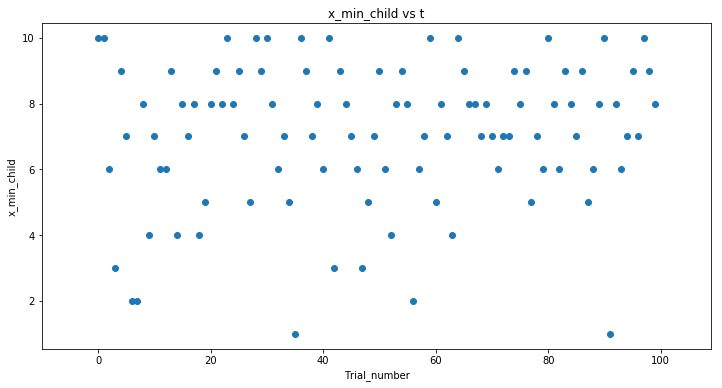

In [134]:
def plot_vals (name):
    f = plt.figure(figsize = (12,6))
    ax = f.add_subplot(111)
    time_vals = [t['tid'] for t in trials3_more.trials]
    min_child_weight = [val["misc"]["vals"][name] for val in trials3_more]
    ax.set_xlim(time_vals[0]-10, time_vals[-1]+10)
    ax.scatter(time_vals, min_child_weight)
    ax.set_title('%s vs t' % name)
    ax.set_xlabel('Trial_number')
    ax.set_ylabel(name)
    plt.show()
plot_vals("x_min_child")

Can't really see it converging anywhere, would likley have to run more than the specified 100 trials to be able to tell 

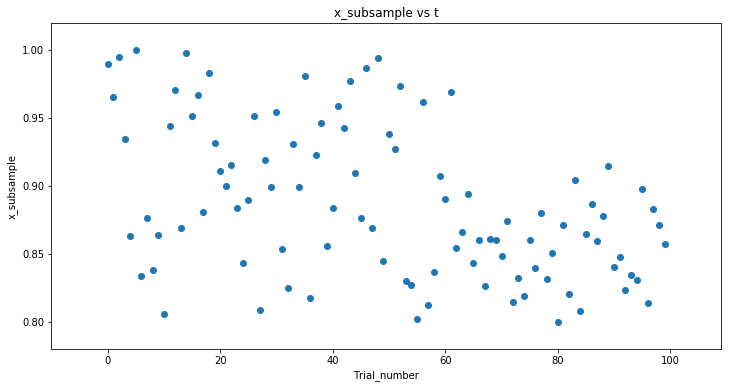

In [135]:
plot_vals("x_subsample")

Seems to be heading towards 0.8, would have to run more tests to be sure

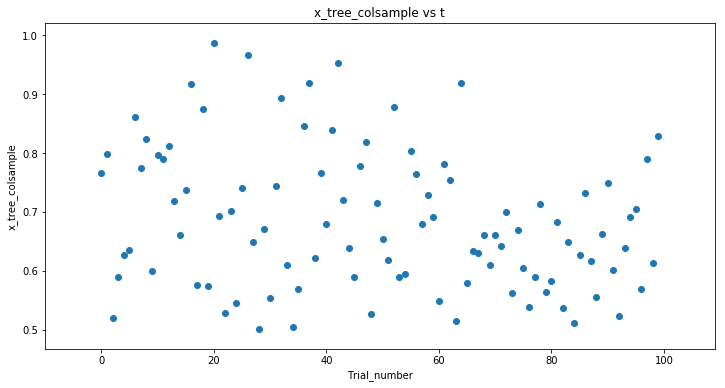

In [136]:
plot_vals("x_tree_colsample")

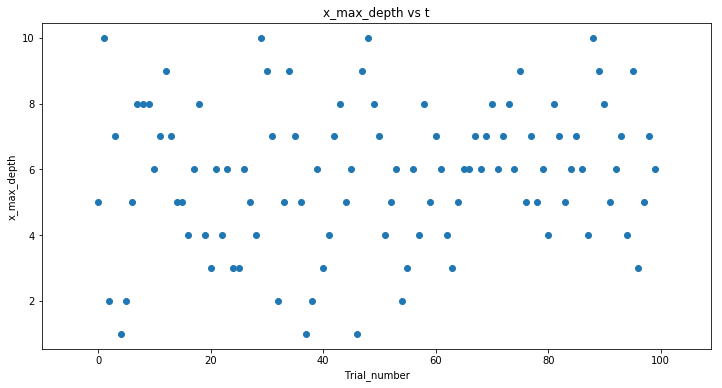

In [137]:
plot_vals("x_max_depth")

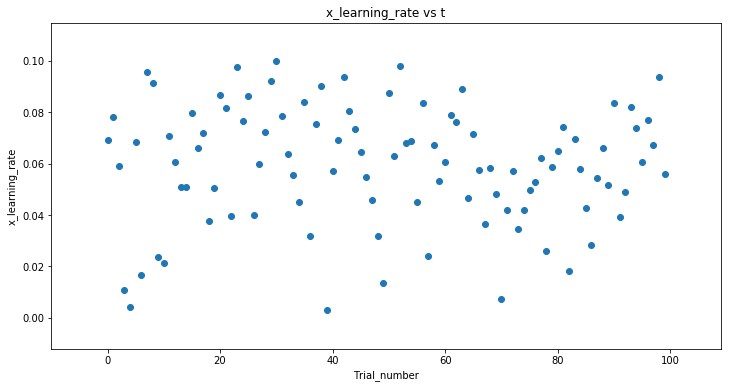

In [138]:
plot_vals("x_learning_rate")


Does appear to be heading towards 0.06, towards the end, less of the values tested are further away for 0.06

In [67]:
#try make three d plot to see if yuo can compare relationship between subsample and col_sample

In [132]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
from matplotlib import cm


def plot_vals_3d (name, name2):
    f = plt.figure(figsize = (12,6))
    ax = f.add_subplot(111, projection = "3d")
    time_vals = [t['tid'] for t in trials3_more.trials]
    param1 = [val["misc"]["vals"][name] for val in trials3_more.trials]
    param2 = [val["misc"]["vals"][name2] for val in trials3_more.trials]

    
    
    x1 = np.asarray(param1).reshape(len(param1))
    y1 = np.asarray(param2).reshape(len(param2))
    
    
    #surf = ax.plot_trisurf(x1, y1, time_vals, cmap=cm.jet, linewidth=0)
    #f.colorbar(time_vals)
    scat = ax.scatter(param1, param2, time_vals, c = np.linspace(0,100,100), cmap = cm.jet)
    m = cm.ScalarMappable(cmap=cm.jet, norm=scat.norm)
    m.set_array(time_vals)
    f.colorbar(m)
    ax.tick_params(axis='both', which='major', pad=3)

    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(6))
    ax.zaxis.set_major_locator(MaxNLocator(5))

    ax.set_title('%s vs %s' % (name, name2))
    ax.set_xlabel(name, labelpad=5)
    ax.set_ylabel(name2, labelpad=5)
    ax.set_zlabel('Trial Number', labelpad=5)
    #ax.view_init(elev=10, azim=10)
    ax.view_init(elev=30, azim=30)  
    plt.show()

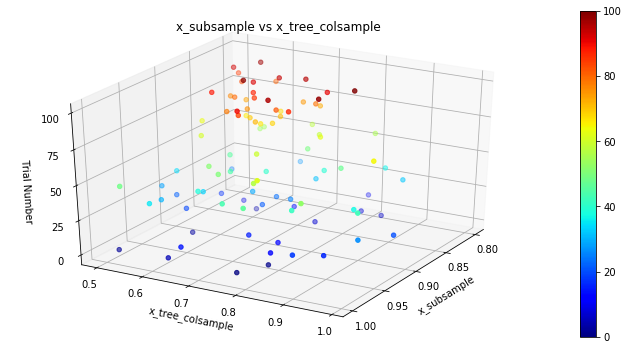

In [133]:
plot_vals_3d("x_subsample", "x_tree_colsample")

This above plot shows that as time passes by, the hyperopt selects parameters mostly concentrated around one area

In [140]:
#back to the model
best_model2

XGBClassifier(base_score=0.5, colsample_bylevel=1,
       colsample_bytree=0.599441393371, gamma=0,
       learning_rate=0.0517038760567, max_delta_step=0, max_depth=10,
       min_child_weight=7.0, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.836607086657)

3531


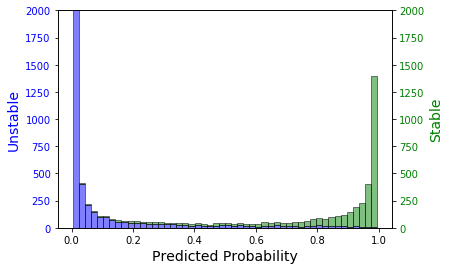

In [147]:
preds = best_model2.predict_proba(testX)[:,1]

bins = 50
Stable=preds[np.where(testY==1)]
Unstable=preds[np.where(testY==0)]

fig, ax1 = plt.subplots()
ax1.hist([Unstable, Stable], bins, alpha=0.5, label='No', color=['blue', 'green'], linewidth = 1, edgecolor='black', histtype='barstacked')
#ax1.hist(Stable, bins, alpha=0.5, label='Yes',color='green', linewidth = 1, edgecolor='black', histtype='barstacked')
print Stable.size
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')


ax2 = ax1.twinx()
#ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', linewidth = 1, edgecolor='black', histtype='barstacked')
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')

#ax1.set_ylim(ax2.get_ylim())
ylim = 2000
ax1.set_ylim([0,ylim])
ax2.set_ylim([0,ylim])

plt.show()

In [149]:
from sklearn.metrics import roc_curve
tpr, fpr, thresholds = roc_curve( testY, preds)

for i in range(0,len(fpr), 10):
    print("Threshold {0}, FPR = {1}, TPR = {2}".format(thresholds[i], fpr[i], tpr[i]))

Threshold 0.995299577713, FPR = 0.000283205890683, TPR = 0.0
Threshold 0.989590704441, FPR = 0.17417162277, TPR = 0.000182848784056
Threshold 0.98134046793, FPR = 0.334466156896, TPR = 0.000548546352167
Threshold 0.968991041183, FPR = 0.4437836307, TPR = 0.00127994148839
Threshold 0.957026481628, FPR = 0.499008779383, TPR = 0.00219418540867
Threshold 0.94876563549, FPR = 0.531577456811, TPR = 0.003291278113
Threshold 0.934951901436, FPR = 0.571792693288, TPR = 0.00438837081733
Threshold 0.930219829082, FPR = 0.583404134806, TPR = 0.00530261473761
Threshold 0.925288259983, FPR = 0.594165958652, TPR = 0.00621685865789
Threshold 0.914120554924, FPR = 0.620504106485, TPR = 0.00713110257817
Threshold 0.907161831856, FPR = 0.632965165675, TPR = 0.00804534649845
Threshold 0.894571781158, FPR = 0.658736901728, TPR = 0.00895959041872
Threshold 0.888793408871, FPR = 0.665250637213, TPR = 0.0100566831231
Threshold 0.882274985313, FPR = 0.674596431606, TPR = 0.0111537758274
Threshold 0.87763738632

In [155]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(testY,preds)
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall curve')
print "AUC Score (Test): %f" % average_precision_score(testY, preds)

AUC Score (Test): 0.965028
